# CV Course Project: Image Recognition - Popular Architectures training from Transfer Learning

---

**Group:**
- Alumno 1: San Millan Rodrigues, Nadine (n.srodrigues@alumnos.upm.es)
- Alumno 2: Sukhorukova, Anastasia (anastasia.s@alumnos.upm.es)
- Alumno 3: Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)

**Course:** Computer Vision (CV) - 2025/26

**Institution:** Polytechnic University of Madrid (UPM)

**Date:** January 2026

## 0 Setup and Data Loading

### 0.1 Install and Import Required Libraries

In [1]:
!pip install tensorflow numpy rasterio scikit-learn matplotlib keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 60.0 MB/s eta 0:00:00


Loading the necessary libraries.

In [2]:
# Python libraries
import uuid
import warnings
import json
import os
import math

# External libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, AdamW
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, InceptionV3, ConvNeXtTiny
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import preprocess_input as prepro_res
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as prepro_mobile
from tensorflow.keras.applications.inception_v3 import preprocess_input as prepro_inception
from tensorflow.keras.applications.convnext import preprocess_input as prepro_conv
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import CategoricalCrossentropy


2026-01-01 16:34:32.221658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767285272.441904      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767285272.511939      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Check if GPU is available for training the models.

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### 0.2 Load the Dataset & Image Loader

Before loading the dataset, set the path to the folder containing the images.

In [4]:
IMAGES_PATH = '/kaggle/input/xview-dataset/xview_recognition/'

In [5]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [6]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [7]:
def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(IMAGES_PATH + filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [8]:
# Load database
json_file = IMAGES_PATH + 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [9]:
counts = dict.fromkeys(categories.values(), 0)
anns_dataset = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns_dataset.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [10]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

### 0.3 Setup

In [11]:
# Fix random seed for reproducibility
RANDOM_SEED = 42
def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
set_seed(RANDOM_SEED)

# Number of categories for classification
NUM_CATEGORIES = len(categories)

## 1 Training Popular CNN Architectures from Scratch

### 1.1 Setup

In [12]:
train2, val2 = train_test_split(anns_dataset,
                                test_size=0.1, 
                                random_state=RANDOM_SEED, 
                                stratify=[obj.category for ann in anns_dataset for obj in ann.objects])
print('Number of training images: ' + str(len(train2)))
print('Number of validation images: ' + str(len(val2)))

Number of training images: 16871
Number of validation images: 1875


In [13]:
data_augmentation = Sequential([
    RandomFlip("horizontal", seed=RANDOM_SEED),
    RandomRotation(0.05, seed=RANDOM_SEED),
    RandomZoom(0.05, seed=RANDOM_SEED),
], name="data_augmentation")

# 1. Setting the Input
inputs = Input(shape=(224, 224, 3))
# 2. Add Data Augmentation Layers
x = data_augmentation(inputs)
# 3. Add Preprocessing layer
x = Lambda(prepro_inception)(x)

# Loading the base model...
base_model = InceptionV3(input_tensor = x, # Changing Input
                         weights = 'imagenet', # WEIGHTS INCLUDED FOR TL
                         include_top = False) # Changing 1000-classes output to only 13!

base_model.trainable = False # FREEZING MODEL

# Adding custom classifier head
x = base_model(x, training=False) # FREEZING MODEL
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)

# Final model
model = Model(inputs=inputs, outputs=predictions)
model.summary()

opt =  AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

I0000 00:00:1767285286.872232      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767285286.872807      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,989,613 (87.70 MB)

 Trainable params: 1,185,293 (4.52 MB)

 Non-trainable params: 21,804,320 (83.18 MB)

In [14]:
# Callbacks
MODEL_NAME = 'Popular_Archs_TL.keras'

model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [15]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in train2 for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in val2 for obj in ann.objects]

# Generators
BATCH_SIZE = 32
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

### 1.2 Training

In [16]:
print('Training model...')

EPOCHS = 70
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

h1 = model.fit(train_generator, 
              steps_per_epoch=train_steps, 
              validation_data=valid_generator, 
              validation_steps=valid_steps, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model...
Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1767285308.911043      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2364 - loss: 2.5850

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_accuracy improved from -inf to 0.40160, saving model to Popular_Archs_TL.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 960s 2s/step - accuracy: 0.2365 - loss: 2.5845 - val_accuracy: 0.4016 - val_loss: 1.8741 - learning_rate: 1.0000e-04
Epoch 2/70
527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3701 - loss: 2.0481
Epoch 2: val_accuracy improved from 0.40160 to 0.44907, saving model to Popular_Archs_TL.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 73s 139ms/step - accuracy: 0.3701 - loss: 2.0478 - val_accuracy: 0.4491 - val_loss: 1.7227 - learning_rate: 1.0000e-04
Epoch 3/70
527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4049 - loss: 1.8685
Epoch 3: val_accuracy improved from 0.44907 to 0.47147, saving model to Popular_Archs_TL.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 76s 144ms/step - accuracy: 0.4049 - loss: 1.8684 - val_accuracy: 0.4715 - val_loss: 1.6994 - learning_rate: 1.0000e-04
Epoch 4/70
527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4171 - loss: 1.7966
Epoch 4: va

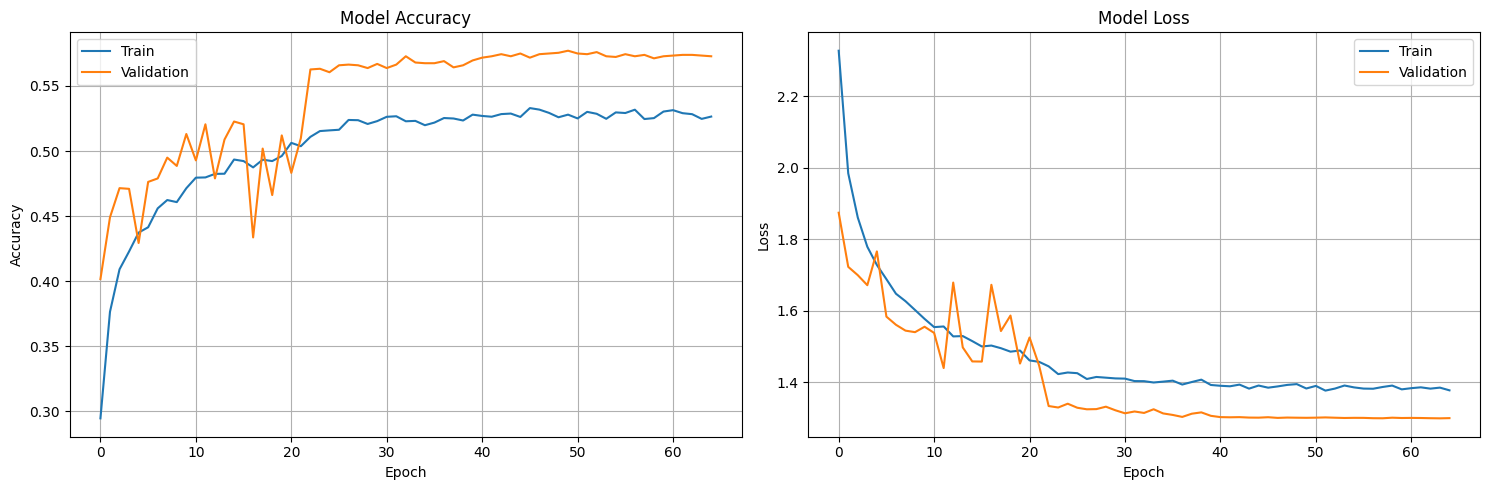

In [17]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Model Accuracy ---
ax1.plot(h1.history['accuracy'])
ax1.plot(h1.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# --- Plot 2: Model Loss ---
ax2.plot(h1.history['loss'])
ax2.plot(h1.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()
fig.savefig('training_plots.png')

#### 1.2.1 Defreezing layers

In [ ]:
model.load_weights(MODEL_NAME)

# total_layers = len(base_model.layers)
# ratio_to_unfreeze = 0.20
# num_layers_unfreeze = int(total_layers * ratio_to_unfreeze)
# fine_tune_at = total_layers - num_layers_unfreeze

# print(f"Total de capas: {total_layers}")
# print(f"Descongelando el 20% superior ({num_layers_unfreeze} capas)...")
# print(f"Punto de corte: capa {fine_tune_at}")

# DesCongelando todas las capas
base_model.trainable = True
#for layer in base_model.layers[:fine_tune_at]:
#    layer.trainable = False

# RE-COMPILAR
opt_finetune = AdamW(learning_rate=1e-5, weight_decay=1e-4)
model.compile(optimizer=opt_finetune,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
MODEL_NAME_FT = 'Popular_Archs_TL_FT.keras'
model_checkpoint = ModelCheckpoint(MODEL_NAME_FT, monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

# Entrenar de nuevo (Fine-Tuning)
EPOCHS = 40
h2 = model.fit(train_generator,
                         steps_per_epoch=train_steps, 
                         validation_data=valid_generator,
                         validation_steps=valid_steps, 
                         epochs=EPOCHS,
                         callbacks=callbacks,
                        verbose=1)

# Best validation model
best_idx = int(np.argmax(h2.history['val_accuracy']))
best_value = np.max(h2.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.3171 - loss: 2.3348

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to Popular_Archs_TL_FT.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 268s 390ms/step - accuracy: 0.3172 - loss: 2.3340 - val_accuracy: 0.4667 - val_loss: 1.7364 - learning_rate: 1.0000e-05
Epoch 2/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5159 - loss: 1.4700
Epoch 2: val_accuracy improved from 0.46667 to 0.55467, saving model to Popular_Archs_TL_FT.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 200s 379ms/step - accuracy: 0.5160 - loss: 1.4698 - val_accuracy: 0.5547 - val_loss: 1.3415 - learning_rate: 1.0000e-05
Epoch 3/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5798 - loss: 1.2352
Epoch 3: val_accuracy improved from 0.55467 to 0.61867, saving model to Popular_Archs_TL_FT.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 200s 379ms/step - accuracy: 0.5798 - loss: 1.2352 - val_accuracy: 0.6187 - val_loss: 1.1519 - learning_rate: 1.0000e-05
Epoch 4/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.6207 - loss: 1.12

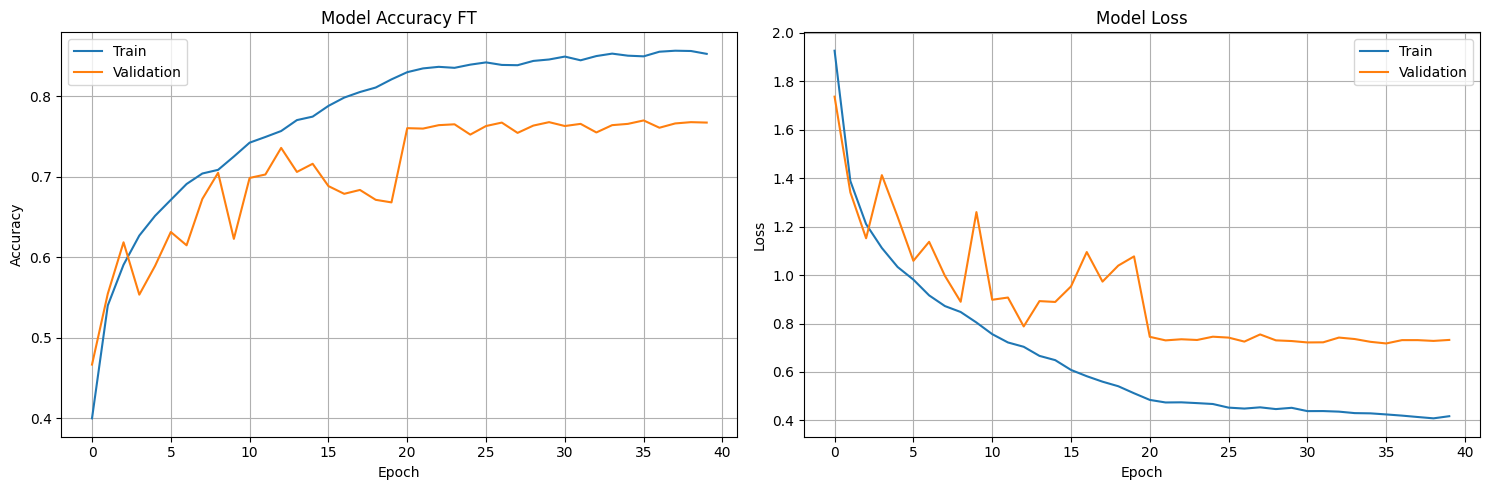

In [19]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Model Accuracy ---
ax1.plot(h2.history['accuracy'])
ax1.plot(h2.history['val_accuracy'])
ax1.set_title(f'Model Accuracy FT')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# --- Plot 2: Model Loss ---
ax2.plot(h2.history['loss'])
ax2.plot(h2.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()
fig.savefig('training_plots_defreeze.png')

## 2 Validation

In [20]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

    # Save confusion matrix figure
    fig.savefig('confusion_matrix.png')

In [21]:
model.load_weights(MODEL_NAME_FT)
y_true, y_pred = [], []
for ann in val2:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


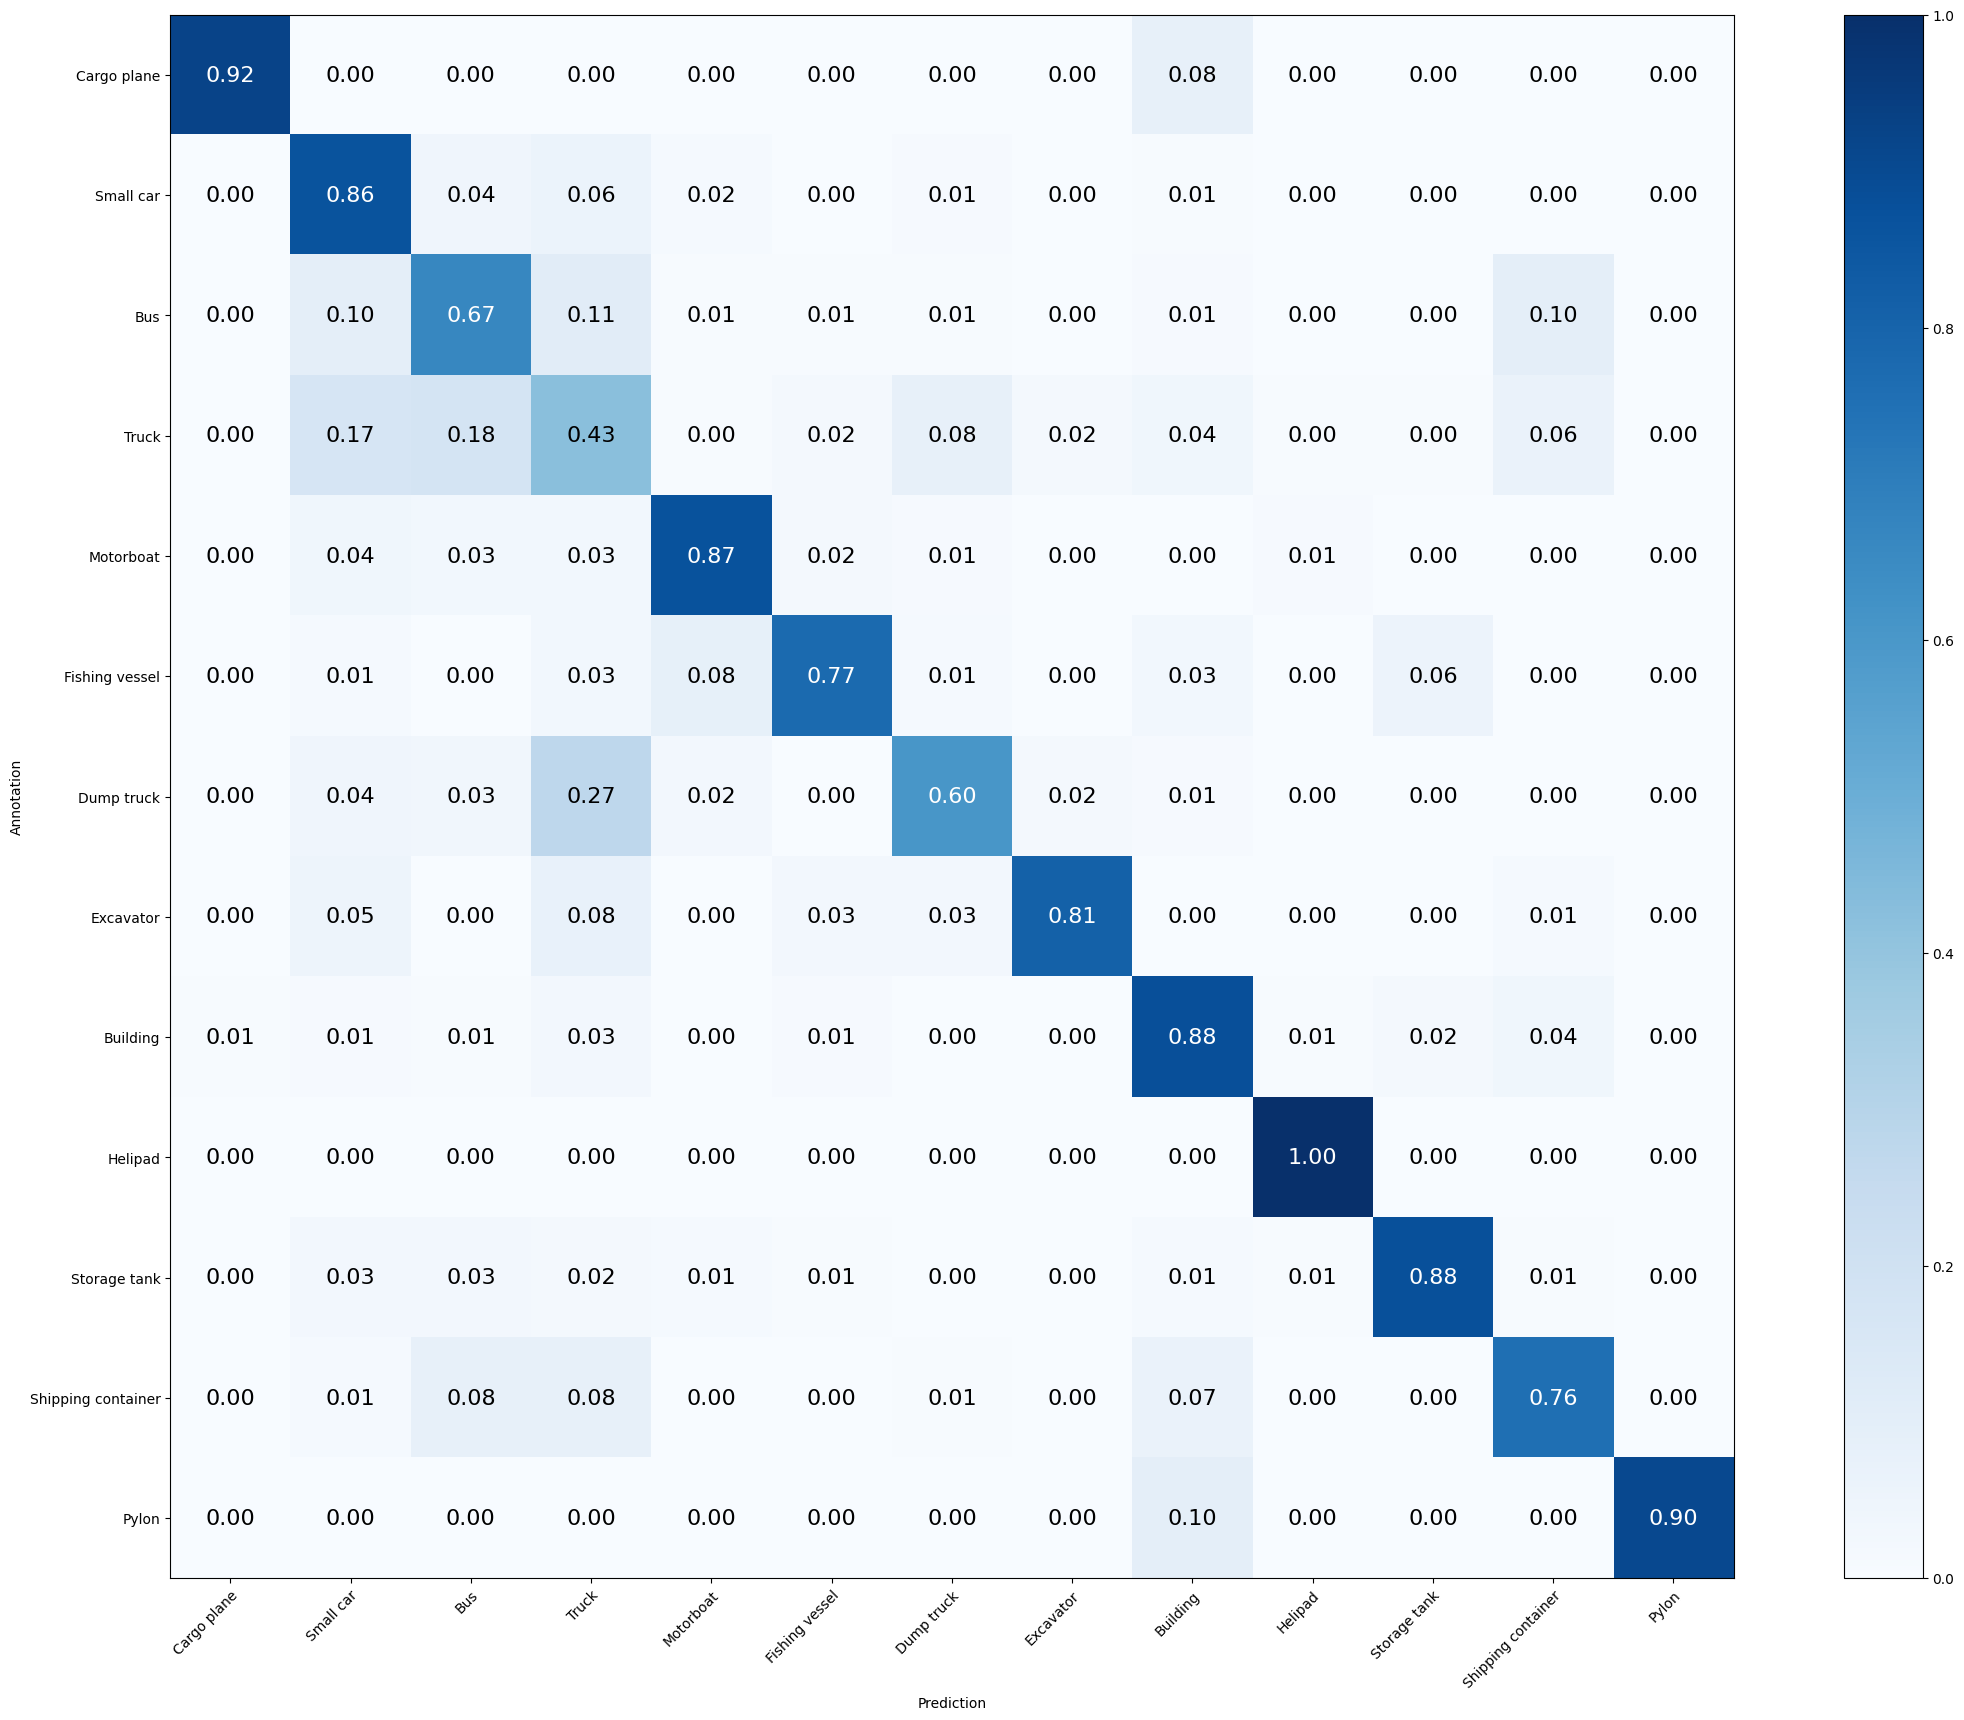

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [23]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 77.013%
Mean Recall: 79.651%
Mean Precision: 79.087%
> Cargo plane: Recall: 92.188% Precision: 96.721% Specificity: 99.890% Dice: 94.400%
> Small car: Recall: 86.446% Precision: 78.846% Specificity: 95.010% Dice: 82.471%
> Bus: Recall: 66.667% Precision: 60.204% Specificity: 95.406% Dice: 63.271%
> Truck: Recall: 42.534% Precision: 46.305% Specificity: 93.410% Dice: 44.340%
> Motorboat: Recall: 86.916% Precision: 83.036% Specificity: 98.925% Dice: 84.932%
> Fishing vessel: Recall: 77.465% Precision: 80.882% Specificity: 99.279% Dice: 79.137%
> Dump truck: Recall: 60.484% Precision: 73.529% Specificity: 98.458% Dice: 66.372%
> Excavator: Recall: 81.013% Precision: 90.141% Specificity: 99.610% Dice: 85.333%
> Building: Recall: 88.022% Precision: 90.028% Specificity: 97.691% Dice: 89.014%
> Helipad: Recall: 100.000% Precision: 68.750% Specificity: 99.732% Dice: 81.481%
> Storage tank: Recall: 87.755% Precision: 92.143% Specificity: 99.363% Dice: 89.895%
> Shipping container

## 3 Testing

In [24]:
anns = []
i = 0
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/xview-dataset/xview_recognition/xview_test/'):
    for filename in filenames:
        image = GenericImage(dirpath + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [25]:
model.load_weights(MODEL_NAME_FT)
predictions_data = {"images": {}, "annotations": {}}

for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage("/".join(ann.filename.split('/')[-3:]))
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [26]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)